# Imports

In [169]:
import os
import torch
import torch.nn as nn
import numpy as np
from IPython import embed
from skimage import color
from PIL import Image
from torch.utils.data import Dataset, IterableDataset
from torchsummary import summary
from tqdm.notebook import trange, tqdm
from torch.nn.utils.clip_grad import clip_grad_norm_
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10, CelebA, Caltech256
import numpy as np
from skimage import color, io
import matplotlib.pyplot as plt
import torchvision.


SyntaxError: ignored

In [101]:
# Hyper parameters and others
lr = 1e-2
epochs = 45
batch_size = 8
dp_save_path = "/content/dp.ckpt"
dp_save_path2 = "/content/dp2.ckpt"

# Data

In [147]:
def import_image(img):
    if len(np.array(img).shape) != 3:
      return torch.FloatTensor(np.transpose(color.rgb2lab(np.stack([np.array(img)]*3, axis = 2)), (2, 0, 1)))
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))
    
img_transform = transforms.Compose([
    transforms.Lambda(import_image),
    transforms.Resize((32,32))
])
train_dataset = CIFAR10('./data/CIFAR10', train=True, transform=img_transform, target_transform=None, download=True)
test_dataset = CIFAR10('./data/CIFAR10', train=False, transform=img_transform, target_transform=None, download=True)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.9, 0.1])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# train_dataset = Caltech256('./data/Caltech256', transform=img_transform, target_transform=None, download=True)
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.1, 0.1])


# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


# Our Model

In [144]:
class ColorNet(nn.Module):
    def __init__(self):
        super(ColorNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) 
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) 
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) 
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1) 
        self.conv4_bn = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1) 
        self.conv5_bn = nn.BatchNorm2d(256)
        # self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1) 
        # self.conv6_bn = nn.BatchNorm2d(256)
        # self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1) 
        # self.conv7_bn = nn.BatchNorm2d(256)

        self.rconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1) 
        self.rconv1_bn = nn.BatchNorm2d(128)
        self.rconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) 
        self.rconv2_bn = nn.BatchNorm2d(64)
        self.rconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) 
        self.rconv3_bn = nn.BatchNorm2d(32)
        self.rconv4 = nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1) 

    def forward(self, input):
        x = F.relu(self.conv1_bn(self.conv1(input)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        # x = F.relu(self.conv6_bn(self.conv6(x)))
        # x = F.relu(self.conv7_bn(self.conv7(x)))

        x = F.relu(self.rconv1_bn(self.rconv1(x)))
        x = F.relu(self.rconv2_bn(self.rconv2(x)))
        x = F.relu(self.rconv3_bn(self.rconv3(x)))
        x = self.rconv4(x)

        return x

In [145]:
cmodel1 = ColorNet()
optimizer = torch.optim.Adam(params=cmodel1.parameters(), lr=lr)

In [148]:
def forward(x, model):
    res = model(x)
    return res 

def cal_loss(res, targets):
    loss = F.mse_loss(res, targets)
    return loss

def train_batch(batch, model):
    batch = batch[0]
    inputs, targets = batch[:, 0:1, :, :], batch[:, 1:3, :, :]
    res = forward(inputs, model)

    loss = cal_loss(res, targets)
    return loss


def training_step(batch, model):
    model.train()
    loss = train_batch(batch, model)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return abs(loss.item())

def val(batch, model):
    model.eval()
    batch = batch[0]
    inputs, targets = batch[:, 0:1, :, :], batch[:, 1:3, :, :]
    res = forward(inputs, model)
    loss = cal_loss(res, targets)
    return abs(loss.item())



if os.path.exists(dp_save_path):
  cmodel1.load_state_dict(torch.load(dp_save_path))

losses1 = []
losses1_val = []
# training loop
for epoch in range(0, epochs):
    pbar = None
    pbar = tqdm(train_dataloader, leave=True, total= len(train_dataloader))
    outputs = []
    vals = []

    for batch_nb, batch in enumerate(pbar):
        loss = training_step(batch, cmodel1)
        outputs.append(loss)
    
    pbar2 = tqdm(val_dataloader, leave=True, total= len(val_dataloader))

    for batch_nb, batch in enumerate(pbar2):
        loss = val(batch, cmodel1)
        vals.append(loss)
    

    train_result = np.mean(outputs)
    val_result = np.mean(vals)
    losses1.append(train_result)
    losses1_val.append(val_result)
    print('epoch = {}, train_loss = {} val_loass = {}'.format(epoch, train_result, val_result)) 
    print("saving checkpoint")
    torch.save(cmodel1.state_dict(), dp_save_path)

  0%|          | 0/5625 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

#Rebalance loss

In [149]:
def bmse_loss(inputs, targets):
    mse_loss = (inputs - targets) ** 2
    weights = torch.log(torch.abs(targets)+1)+1
    mse_loss = mse_loss*weights
    mse_loss = mse_loss.mean()/torch.sum(weights)
    return mse_loss

In [150]:
cmodel2 = ColorNet()
optimizer = torch.optim.Adam(params=cmodel2.parameters(), lr=lr)

In [151]:
def cal_loss(res, targets):
    loss = bmse_loss(res, targets)
    return loss


if os.path.exists(dp_save_path2):
  cmodel2.load_state_dict(torch.load(dp_save_path2))

losses2 = []
losses2_val = []
# training loop
for epoch in range(0, epochs):
    pbar = None
    pbar = tqdm(train_dataloader, leave=True, total= len(train_dataloader))
    outputs = []
    vals = []

    for batch_nb, batch in enumerate(pbar):
        loss = training_step(batch, cmodel2)
        outputs.append(loss)
    
    pbar2 = tqdm(val_dataloader, leave=True, total= len(val_dataloader))

    for batch_nb, batch in enumerate(pbar2):
        loss = val(batch, cmodel2)
        vals.append(loss)
    
    train_result = np.mean(outputs)
    losses2.append(train_result)
    val_result = np.mean(vals)
    losses2_val.append(val_result)
    print('epoch = {}, train_loss = {} val_loss = {}'.format(epoch, train_result, val_result)) 
    print("saving checkpoint")
    torch.save(cmodel2.state_dict(), dp_save_path2)

  0%|          | 0/5625 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

#Result

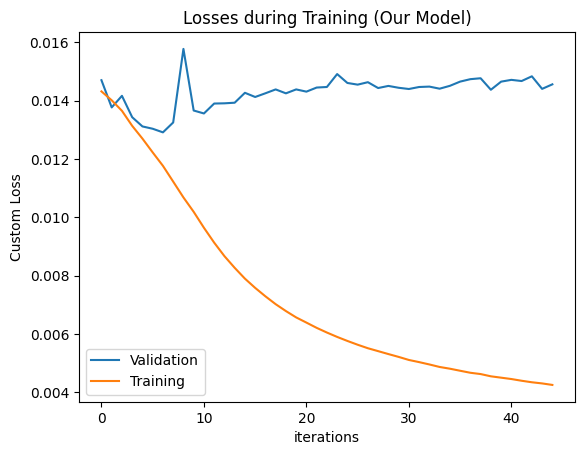

In [28]:
plt.plot(losses2_val, label = "Validation")
plt.plot(losses2, label = "Training")
plt.xlabel("iterations")
plt.ylabel("Custom Loss")
plt.title("Losses during Training (Our Model)")
plt.legend()
plt.show()

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[10.84907  32.08125  11.427812 19.469343 17.421974 14.08749  15.327812
  8.238816  7.833824 15.718152 10.60335   8.748699 17.557817  9.175346
 22.95742   9.47043 ]


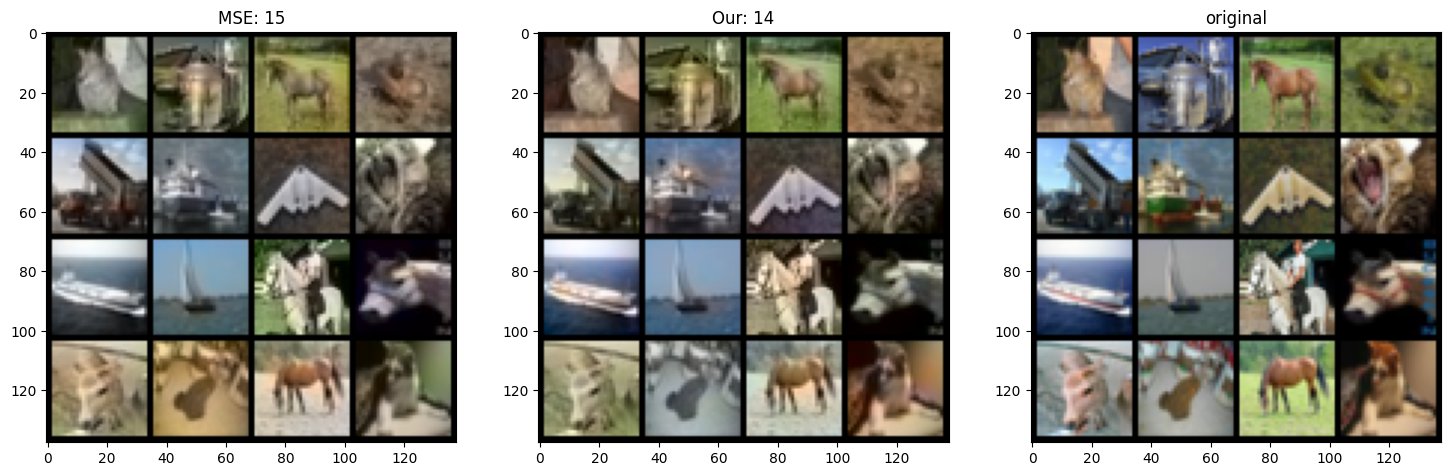

In [199]:
plt.ion()

with torch.no_grad():
    x = 46
    image_inds = list(range(x,x+16))
    lab_batch = torch.stack([test_dataset[i][0] for i in image_inds])

    # predict colors (ab channels)
    predicted_ab_batch = cmodel1(lab_batch[:, 0:1, :, :])
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)
    #get diff between out and original images
    diff=predicted_lab_batch-lab_batch

    diffL=np.array(diff[:, 0,  :, :,])
    diffa=np.array(diff[:, 1,  :, :,])
    diffb=np.array(diff[:, 2,  :, :,])
    delta=np.mean(np.sqrt((diffL*diffL)+(diffa*diffa)+(diffb*diffb)), axis = (1,2))
    delta = int(np.mean(delta))

    # predict colors (ab channels)
    predicted_ab_batch2 = cmodel2(lab_batch[:, 0:1, :, :])
    predicted_lab_batch2 = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch2], dim=1)
    diff=predicted_lab_batch2-lab_batch
    diffL=np.array(diff[:, 0,  :, :,])
    diffa=np.array(diff[:, 1,  :, :,])
    diffb=np.array(diff[:, 2,  :, :,])
    delta2=np.mean(np.sqrt((diffL*diffL)+(diffa*diffa)+(diffb*diffb)), axis = (1,2))
    print(delta2)
    delta2 = int(np.mean(delta2))

    # convert to rgb
    rgb_batch = []
    predicted_rgb_batch = []
    predicted_rgb_batch2 = []

    for i in range(lab_batch.size(0)):
        # original
        rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))

        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

        predicted_rgb_img2 = color.lab2rgb(np.transpose(predicted_lab_batch2[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch2.append(torch.FloatTensor(np.transpose(predicted_rgb_img2, (2, 0, 1))))

    # plot images
    fig, ax = plt.subplots(figsize=(18, 18), nrows=1, ncols=3)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=4).numpy(), (1, 2, 0)))
    ax[0].title.set_text('MSE: {}'.format(delta))
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch2), nrow=4).numpy(), (1, 2, 0)))
    ax[1].title.set_text('Our: {}'.format(delta2))
    ax[2].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=4).numpy(), (1, 2, 0)))
    ax[2].title.set_text('original')
    plt.show()

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 9 pixels
  ret

[ 7.5002284  6.1614933  6.1940126  7.2234273 12.098417   5.6313763
  7.344143   9.291559   8.70939    8.407495  10.533775  13.060284
 10.197135   9.8986845  4.444591   5.6577578]


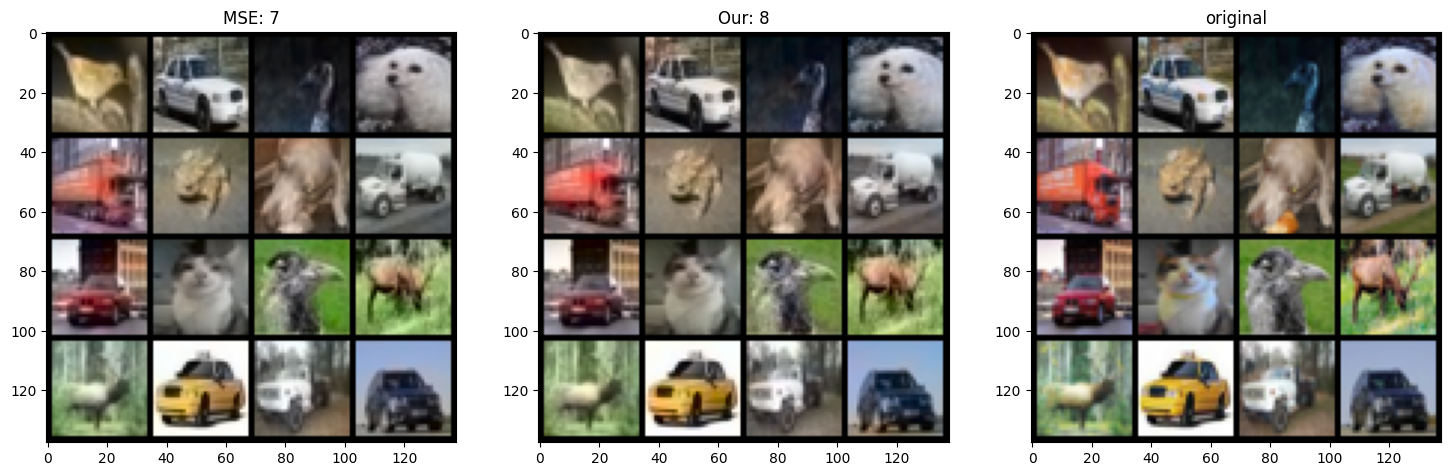

In [189]:
plt.ion()

with torch.no_grad():
    x = 46
    image_inds = list(range(x,x+16))
    lab_batch = torch.stack([train_dataset[i][0] for i in image_inds])

    # predict colors (ab channels)
    predicted_ab_batch = cmodel1(lab_batch[:, 0:1, :, :])
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)
    #get diff between out and original images
    diff=predicted_lab_batch-lab_batch

    diffL=np.array(diff[:, 0,  :, :,])
    diffa=np.array(diff[:, 1,  :, :,])
    diffb=np.array(diff[:, 2,  :, :,])
    delta=np.mean(np.sqrt((diffL*diffL)+(diffa*diffa)+(diffb*diffb)), axis = (1,2))
    delta = int(np.mean(delta))

    # predict colors (ab channels)
    predicted_ab_batch2 = cmodel2(lab_batch[:, 0:1, :, :])
    predicted_lab_batch2 = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch2], dim=1)
    diff=predicted_lab_batch2-lab_batch
    diffL=np.array(diff[:, 0,  :, :,])
    diffa=np.array(diff[:, 1,  :, :,])
    diffb=np.array(diff[:, 2,  :, :,])
    delta2=np.mean(np.sqrt((diffL*diffL)+(diffa*diffa)+(diffb*diffb)), axis = (1,2))
    delta2 = int(np.mean(delta2))

    # convert to rgb
    rgb_batch = []
    predicted_rgb_batch = []
    predicted_rgb_batch2 = []

    for i in range(lab_batch.size(0)):
        # original
        rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))

        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

        predicted_rgb_img2 = color.lab2rgb(np.transpose(predicted_lab_batch2[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch2.append(torch.FloatTensor(np.transpose(predicted_rgb_img2, (2, 0, 1))))

    # plot images
    fig, ax = plt.subplots(figsize=(18, 18), nrows=1, ncols=3)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=4).numpy(), (1, 2, 0)))
    ax[0].title.set_text('MSE: {}'.format(delta))
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch2), nrow=4).numpy(), (1, 2, 0)))
    ax[1].title.set_text('Our: {}'.format(delta2))
    ax[2].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=4).numpy(), (1, 2, 0)))
    ax[2].title.set_text('original')
    plt.show()

In [183]:
with torch.no_grad():
  lab_batch = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])
  # predict colors (ab channels)
  predicted_ab_batch = cmodel1(lab_batch[:, 0:1, :, :])
  predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)
  #get diff between out and original images
  diff=predicted_lab_batch-lab_batch

  diffL=np.array(diff[:, 0,  :, :,])
  diffa=np.array(diff[:, 1,  :, :,])
  diffb=np.array(diff[:, 2,  :, :,])
  delta=np.round(np.mean(np.sqrt((diffL*diffL)+(diffa*diffa)+(diffb*diffb)), axis = 0), decimals = 2)
  delta = np.mean(delta)

  # predict colors (ab channels)
  predicted_ab_batch2 = cmodel2(lab_batch[:, 0:1, :, :])
  predicted_lab_batch2 = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch2], dim=1)
  diff=predicted_lab_batch2-lab_batch
  diffL=np.array(diff[:, 0,  :, :,])
  diffa=np.array(diff[:, 1,  :, :,])
  diffb=np.array(diff[:, 2,  :, :,])
  delta2=np.round(np.mean(np.sqrt((diffL*diffL)+(diffa*diffa)+(diffb*diffb)), axis = 0), decimals = 2)
  delta2 = np.mean(delta2)

print(delta, delta2)


14.155908 14.897159


In [191]:
with torch.no_grad():
  lab_batch = torch.stack([train_dataset[i][0] for i in range(10000)])
  # predict colors (ab channels)
  predicted_ab_batch = cmodel1(lab_batch[:, 0:1, :, :])
  predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)
  #get diff between out and original images
  diff=predicted_lab_batch-lab_batch

  diffL=np.array(diff[:, 0,  :, :,])
  diffa=np.array(diff[:, 1,  :, :,])
  diffb=np.array(diff[:, 2,  :, :,])
  delta=np.round(np.mean(np.sqrt((diffL*diffL)+(diffa*diffa)+(diffb*diffb)), axis = 0), decimals = 2)
  delta = np.mean(delta)

  # predict colors (ab channels)
  predicted_ab_batch2 = cmodel2(lab_batch[:, 0:1, :, :])
  predicted_lab_batch2 = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch2], dim=1)
  diff=predicted_lab_batch2-lab_batch
  diffL=np.array(diff[:, 0,  :, :,])
  diffa=np.array(diff[:, 1,  :, :,])
  diffb=np.array(diff[:, 2,  :, :,])
  delta2=np.round(np.mean(np.sqrt((diffL*diffL)+(diffa*diffa)+(diffb*diffb)), axis = 0), decimals = 2)
  delta2 = np.mean(delta2)

print(delta, delta2)

8.228164 8.712412


# Fun


/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 39 pixels
  return func(*args, **kwargs)


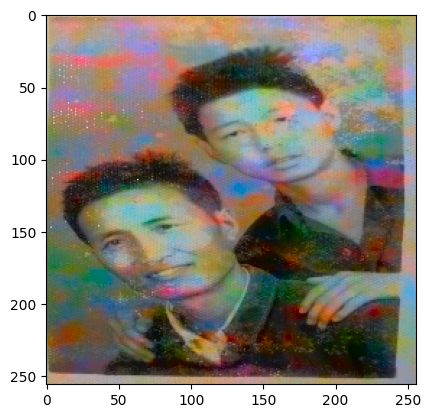

In [227]:
import cv2
im = cv2.imread("/content/Image from iOS.jpg")
im = cv2.imread("/content/IMG_4868.JPG")
im = cv2.imread("/content/IMG_4866.JPG")

im = cv2.resize(im, (256, 256))

im = torch.FloatTensor([
    np.transpose(color.rgb2lab(im), (2, 0, 1)),
    np.transpose(color.rgb2lab(im), (2, 0, 1)),
    np.transpose(color.rgb2lab(im), (2, 0, 1))
    ])
with torch.no_grad():
  predicted_ab_batch = cmodel2(im[:, 0:1, :, :])
  # print(im.size(), predicted_ab_batch.size())
  # predicted_lab_batch = torch.cat([im[:, 0:1, :1632, :1168], predicted_ab_batch], dim=1)
  predicted_lab_batch = torch.cat([im[:, 0:1, :, :], predicted_ab_batch], dim=1)

  for i in range(predicted_lab_batch.size(0)):
        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))

  plt.imshow(predicted_rgb_img)
 